# <font color = 'pickle'>**What is RAG?**

RAG stands for Retrieval Augmented Generation.

The goal of RAG is to take information and pass it to a LLM (large language model) so it can generate outputs based on that information. Consider when you are using ChatGPT and you attach a file within the chat and ask ChatGPT to answer you based on the text. RAG does this process by doing three steps.

- **Retrival**: Finding the relevant information given a query, 'what are the key processes in the ATP-PCr system'-> the pipeline retrieves the relevant passages of text relevant to this question from a specific text book or given body of text.
- **Augmented**: We take the information given from the text and augment our input (the prompt) to an LLM with that relevant information.
- **Generation**: Take the inputs from the first two steps and pass them to an LLM for generative outputs in the form of a chatbot.

## <font color = 'Pickle'>**Why use RAG?**

- The main goal of using RAG is to improve the output generation of LLMs.
- Generally models such as ChatGPT are trained on terabytes of text data from the internet and give general responses to the prompt above.
- The responses look nice from ChatGPT but may be slightly innacurrate, a term in the AI space called hallucinations.
The reasons for these hallucinations is that the models understand the given language on a general context and not a specific context.
- Another isssue is that in most business settings the data that is needed to generate better outputs is often private or not readily available for use the current LLM chatbots.
- This is where RAG comes in, companies can build their own RAG pipelines to plug their data into a LLM in a secure way and create more specific responses based on that data.
- This process is a hot topic in AI today and has a lot of potential to radically change the worlds outlook on search engines.

## <font color = 'pickle'>**What can RAG be used for?**
- **Customer Support Q&A:**
  - A customer support chat bot can be built by treating existing customer support documents as a resource and when a question is asked to the chatbot we can retrieve relevant document snippets from your resources and generate a response from that information in a digestible way.
  - Think about this as a chatbot for documentation.
- **Email chain analysis**
  - A large insuranc company with chains of emails of customer claims can use a RAG pipeline to find relevant information from those store emails and use an LLM to process that information into a structured format.
- **Textbook Q&A**
  - Pretend like you are a student studying exercise physiolpogy or work in sports medicine and you have a 1000 page textbook on that you regularly refer to for questions.
  - A RAG pipeline can go through that textbook and find relevant information on the questions you have.

The common theme is that you are taking relevant documents and attaching them to a query and processing them with an LLM.

The LLM is acting as a sort of calculator for words in this context.


## <font color = 'pickle'>**What's the goal of this notebook?**
- I want to build a chabot that can query a body of text, yes, but I also am interested in exercise physiology since that's what I got my undergrad in.
- So, I'm going to build a chatbot that can query an ex-phys textbook for practice and for my general interest.
- Let's get started!


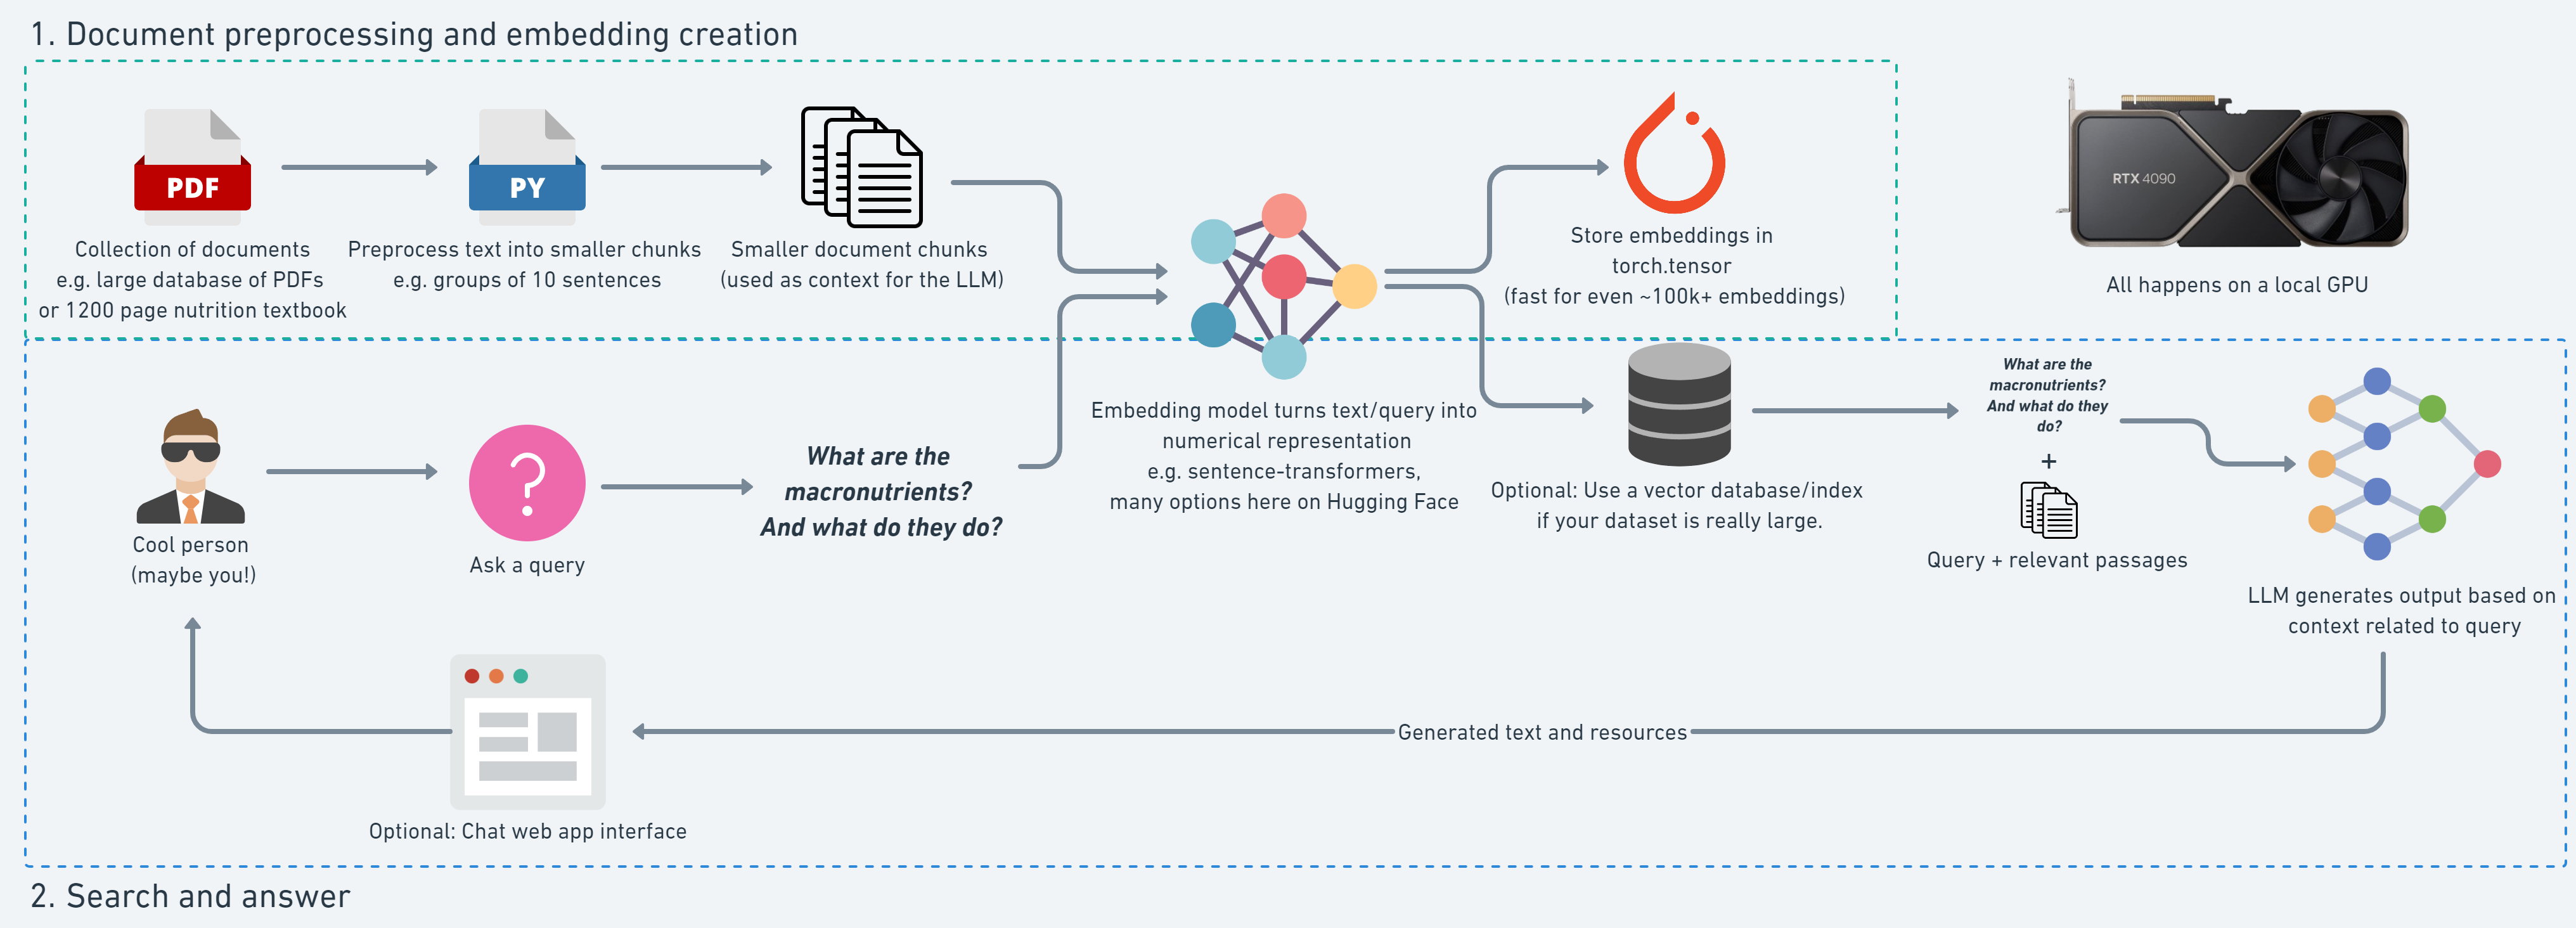

Image Source: https://github.com/mrdbourke/simple-local-rag/blob/main/images/simple-local-rag-workflow-flowchart.png

I am not going to be using a local GPU, because I don't have access to one, hence why I am using colab.

Also, in his repo he uses a different textbook.

## <font color = 'pickle'>**What is going to be built**

We are going to build a chat-bot (Swole-Chat) to chat with the textbook.

1. We need the PDF (any pdf could be used)
2. Format the text to embeddings from the PDF.
3. Embed all of the chunks of text.
4. Build a system of retrieval that uses a vector search to find the relevant info from a query.
5. Create a prompt to incorporate the retrieved pieces of text.
6. Generate an answer to the query based on the passages of text from the LLM.


So we have two functional steps within this process:
1. Document preprocessing and embedding creation. (Steps 1-3)
2. Search and answer (Steps 4-6)

## <font color = 'pickle'>**Setting up the environment**

In [10]:
    import sys
    if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
        # mount google drive
        from google.colab import drive
        drive.mount('/content/drive')
        # set the base path to a Google Drive folder
        base_path = '/content/drive/MyDrive/Colab Notebooks'
        !pip install PyMuPDF
        !pip install tqdm

        sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Simple file maneuverability packages
from pathlib import Path
import joblib
import os
import requests
# For pymupdf for opening pdf documents
import fitz
# Progress meters
from tqdm.auto import tqdm
# Pandas for data manipulation
import pandas as pd
# Random number generation
import random


In [7]:
base_folder = Path(base_path)

data_folder = base_folder/'datasets/ex_phys_ds'

In [21]:
def text_formatter(text: str) -> str:
    """Performs some minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc), total=doc.page_count):
        text = page.get_text()
        text = text_formatter(text=text)
        pages_and_texts.append({
            'page_number': page_number - 63,
            'page_char_count': len(text),
            'page_word_count': len(text.split()),
            'page_sentence_count_raw': len(text.split(". ")),
            'page_token_count': len(text) / 4,  # Assuming 1 token = 4 characters
            'text': text
        })

    return pages_and_texts

# Folder setup
base_folder = Path(base_path)
data_folder = base_folder / 'datasets/ex_phys_ds'

# PDF path setup
pdf_path = data_folder / 'Exercise Physiology Nutrition, Energy, and Human Performance.pdf'

# Process the PDF
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)

# Output some of the pages for inspection
print(pages_and_texts[0:2])

  0%|          | 0/1090 [00:00<?, ?it/s]

[{'page_number': -63, 'page_char_count': 0, 'page_word_count': 0, 'page_sentence_count_raw': 1, 'page_token_count': 0.0, 'text': ''}, {'page_number': -62, 'page_char_count': 0, 'page_word_count': 0, 'page_sentence_count_raw': 1, 'page_token_count': 0.0, 'text': ''}]


Some of the pages will not have text, I'm going to remove these.

In [22]:
def remove_non_text_pages(pages_and_texts):
    # Remove pages where the text is empty or just whitespace
    cleaned_pages = [page for page in pages_and_texts if page['text'].strip()]
    return cleaned_pages

pages_and_texts = remove_non_text_pages(pages_and_texts)

print(pages_and_texts[0:2])

[{'page_number': -61, 'page_char_count': 75, 'page_word_count': 9, 'page_sentence_count_raw': 1, 'page_token_count': 18.75, 'text': 'EIGHTH EDITION Exercise Physiology Nutrition, Energy, and Human Performance'}, {'page_number': -59, 'page_char_count': 680, 'page_word_count': 89, 'page_sentence_count_raw': 4, 'page_token_count': 170.0, 'text': 'EIGHTH EDITION Exercise Physiology Nutrition, Energy, and Human Performance William D. McArdle Professor Emeritus, Department of Family, Nutrition,   and Exercise Science Queens College of the City University of New York Flushing, New York Exercise Physiologist, Weight Watchers International Frank I. Katch Instructor and Board Member Certificate Program in Fitness Instruction UCLA Extension, Los Angeles, California Former Professor and Chair of Exercise Science University of Massachusetts, Amherst, Massachusetts Victor L. Katch Professor of Movement Science School of Kinesiology Associate Professor, Pediatrics School of Medicine University of Mic

In [23]:
df = pd.DataFrame(pages_and_texts)

df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-61,75,9,1,18.75,"EIGHTH EDITION Exercise Physiology Nutrition, ..."
1,-59,680,89,4,170.00,"EIGHTH EDITION Exercise Physiology Nutrition, ..."
2,-58,3468,522,25,867.00,"Acquisitions Editor: Emily Lupash Supervisor, ..."
3,-57,933,177,4,233.25,"To my wife Kathleen, my best friend and bigges..."
4,-56,4399,675,19,1099.75,vi Preface Since the first edition of our text...


In [24]:
df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1042.000000,1042.00000,1042.000000,1042.000000,1042.000000
mean,486.056622,4006.96929,593.796545,22.600768,1001.742322
std,314.511511,1468.43872,210.769600,21.196259,367.109680
min,-61.000000,75.00000,9.000000,1.000000,18.750000
25%,214.250000,3046.00000,457.750000,15.000000,761.500000
50%,488.500000,4202.00000,622.500000,23.000000,1050.500000
75%,757.750000,5088.25000,750.000000,29.750000,1272.062500
max,1026.000000,7506.00000,1263.000000,616.000000,1876.500000


Token count here is important to think about here specifically because:

1. Embedding models don't deal with infinite tokens.
2. LLM's dont deal with infinte tokens.

Now we need to do some further preprocessing into sentences. We can do this with spacy.


In [26]:
from spacy.lang.en import English

nlp = English()

# Adding a sentence pipeline.

nlp.add_pipe('sentencizer')

# Example of usage
doc = nlp('This is sentence 1. This is sentence 2.')
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is sentence 1., This is sentence 2.]

In [29]:
# Running Spacy on the text
for item in tqdm(pages_and_texts):
  item['sentences'] = list(nlp(item['text']).sents)

  # making sure all sentences are in string format
  item['sentences'] = [str(sentence) for sentence in item['sentences']]

  # counting the sentences
  item['page_sentence_count_spacy'] = len(item['sentences'])



  0%|          | 0/1042 [00:00<?, ?it/s]

In [33]:
random.sample(pages_and_texts, k=1)

[{'page_number': 502,
  'page_char_count': 3028,
  'page_word_count': 431,
  'page_sentence_count_raw': 15,
  'page_token_count': 757.0,
  'text': '504\t Section 4\u2002 •\u2002 Enhancement of Energy Transfer Capacity An electromechanical accommodating resistance instru- ment, termed an isokinetic dynamometer, contains a speed- controlling mechanism that accelerates to a preset, constant  velocity with force application. Once attaining this speed,  the isokinetic loading mechanism adjusts automatically to  provide a counterforce to variations in force generated by  muscle as movement continues throughout the “strength  curve.” Thus, maximum force (or any percentage of maximum  effort) generates throughout the full ROM at a pre-established  velocity of limb movement. This allows training and measure- ment under a continuum from high-velocity (lower-force)  to low-\xadvelocity (higher-force) conditions. A microprocessor  within the dynamometer continuously monitors the immedi- ate level 

In [34]:
# Comparing the Spacy sentence count to the raw
df = pd.DataFrame(pages_and_texts)

df.describe()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1042.000000,1042.00000,1042.000000,1042.000000,1042.000000,1042.000000
mean,486.056622,4006.96929,593.796545,22.600768,1001.742322,24.384837
std,314.511511,1468.43872,210.769600,21.196259,367.109680,12.112691
min,-61.000000,75.00000,9.000000,1.000000,18.750000,1.000000
25%,214.250000,3046.00000,457.750000,15.000000,761.500000,16.250000
50%,488.500000,4202.00000,622.500000,23.000000,1050.500000,25.000000
75%,757.750000,5088.25000,750.000000,29.750000,1272.062500,32.000000
max,1026.000000,7506.00000,1263.000000,616.000000,1876.500000,83.000000


<font color = 'Pickle'>**The page sentence count from spacy and raw are very close.
Only a 2 sentence difference on average.
Now to move on to grouping sentences.**

## <font color='pickle'>**Chunking Sentences for Embedding with `all-mpnet-base-v2`**</font>

I'm using the <font color='pickle'>`all-mpnet-base-v2`</font> model from sentence-transformers to generate sentence embeddings, which has a token limit of 384. To stay within this limit, I need to chunk the text into manageable groups.

### <font color='pickle'>**How I Calculated Sentence Chunks**</font>

To keep it simple, I based my chunking on the relationship between tokens and sentences in my data:

1. **Data Analysis**: On average, each page has 24.4 sentences and about 1001.74 tokens. I used <font color='pickle'>`page_sentence_count_spacy`</font> for accurate sentence counts.
   
2. **Tokens per Sentence**: Each sentence contains approximately <font color='pickle'>41 tokens</font> (calculated by dividing 1001.74 tokens by 24.4 sentences).

3. **Sentences per Chunk**: To ensure each chunk stays within 384 tokens, I divided 384 by 41 tokens per sentence, resulting in about <font color='pickle'>9 sentences per chunk</font>.

### <font color='pickle'>**Why Chunking?**</font>

1. **Efficient Processing**: Breaking text into chunks of 9 sentences ensures each chunk aligns with the model's token capacity and avoids overloading.

2. **Preventing Truncation**: Exceeding 384 tokens could cause the model to truncate text, so <font color='pickle'>9 sentences per chunk</font> ensures full processing without losing content.

3. **Maximizing the Context Window**: By optimizing chunk size, I ensure the model's context window is used efficiently, fitting within its limits while processing as many sentences as possible.

This approach allows for controlled, efficient text processing without loss of information.



In [43]:
tokes_per_sentence = 1001/24.4

In [44]:
print(tokes_per_sentence)

41.02459016393443


In [45]:
round(384/tokes_per_sentence, 2)

9.36

In [47]:
# Defining my chunk size
chunk_size = 9

# Custom function to recursively split a list into desired sizes
def split_list(input_list:list,
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of slice_size (or as close as possible).

    A list of 17 sentences will be split into two lists of [[9], [8]]
    """
    return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)] # the range portion here goes from beginning index to the full length of the list
    # the slice_size part of the range function calls for each iteration (i) to jump by increments of slice_size  (0, slice_size, 2*slice_size etc)

for item in tqdm(pages_and_texts):
  item['sentence_chunks'] = split_list(input_list = item['sentences'],
                                       slice_size = chunk_size)
  item['chunk_count'] = len(item['sentence_chunks'])

  0%|          | 0/1042 [00:00<?, ?it/s]

<font color = 'pickle'>**4 chunks in the page selected below.**

In [48]:
random.sample(pages_and_texts, k=1)

[{'page_number': -53,
  'page_char_count': 6029,
  'page_word_count': 862,
  'page_sentence_count_raw': 47,
  'page_token_count': 1507.25,
  'text': 'ix Acknowledgments We wish to thank many individuals. First, to Dr. Loring   Rowell for his constructive comments on the chapters related  to pulmonary and cardiovascular dynamics during rest and  exercise, particularly the sections related to the possible role  of the venous system as an active vasculature. We thank   Dr. Victor Convertino, U.S. Army Institute of Surgical  Research at Fort Sam Houston, TX, for insightful comments  and suggestions on the microgravity chapter, and Dr. Charles  Tipton, Professor Emeritus, University of Arizona, Tuscon,  AZ, for valuable comments and for providing new informa- tion about the historical development of the physiology of  exercise, including material about the first textbook devoted  to exercise and physiology in the 16th century, and physiology   of exercise textbook used in the late 1800s and

<font color = 'pickle'>**Average number of chunks per page is just above 3.**

In [50]:
df = pd.DataFrame(pages_and_texts)

df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy,chunk_count
count,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00,1042.00
mean,486.06,4006.97,593.80,22.60,1001.74,24.38,3.18
std,314.51,1468.44,210.77,21.20,367.11,12.11,1.34
min,-61.00,75.00,9.00,1.00,18.75,1.00,1.00
25%,214.25,3046.00,457.75,15.00,761.50,16.25,2.00
50%,488.50,4202.00,622.50,23.00,1050.50,25.00,3.00
75%,757.75,5088.25,750.00,29.75,1272.06,32.00,4.00
max,1026.00,7506.00,1263.00,616.00,1876.50,83.00,10.00


## <font color = 'pickle'>**Now to split each chunk into its own object.**

We need each chunk of sentences to have its own embedded representation.
So I will be creating a list of seperate dictionaries each containing a single chunk of sentences with relative information such as the page number and stats of each chunk.



In [ ]:
pages_and_chunks = []

for item in tqdm(pages_and_texts):
  for sentence_chunk in item['sentence_chunks']:
    chunk_dict = {}
    chunk_dict['page_number'] = item['page_number']

    # joining the sentences together in a paragraph like structure to form a single string.
    joined_chunk  = "".join(sentence_chunk).replace(" ", " ").strip()
    joined_chunk = re.sub(r'\.(A-Z])', r'. \1', joined_chunk) #